In [1]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn

In [2]:
def magnitude(vector): 
    #Funcion para calcular radio de eventos al centro del detector
    
    norm = []
    for vec in vector:
    	norm.append(np.linalg.norm(vec))

    return np.array(norm, dtype = np.float32)

# 1 - Extracting Data and Moving to GPU

In [6]:
file = uproot.open("/snoplus simulations/electron bulk/random point/random dir/High Statistic/simu_Analysis_elec_5MeV.root")
file.keys()

['T;61', 'T;60', 'pmt;2', 'pmt;1']

In [7]:
data1 = file['T;61']
data1.keys()

['evtid',
 'mcID',
 'energy',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

In [8]:
pmt_info = file['pmt;1']
pmt_info.keys()

['pmt_id', 'pmt_pos_xyz', 'pmt_pos_sph', 'pmt_type']

## 1.1 - EV info

In [9]:
#evtid = np.array(data1['evtid'], dtype = np.int16)
#mcID = np.array(data1['mcID'], dtype = np.int16)
mc_position = np.array(data1['mc_position'])  # -> Position Generation
mc_momentum = np.array(data1['mc_momentum'])  # -> IMPORTANT: Direction of simulated event
position = np.array(data1['position'])        
hit_pmtid = np.array(data1['hit_pmtid'], dtype = np.int16)
time_residual = np.array(data1['hit_residual'])
hit_type = np.array(data1['hit_type'], dtype = np.int16)

## 1.1 - PMT info

In [10]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

# 2 - Observe Data - Time Residual

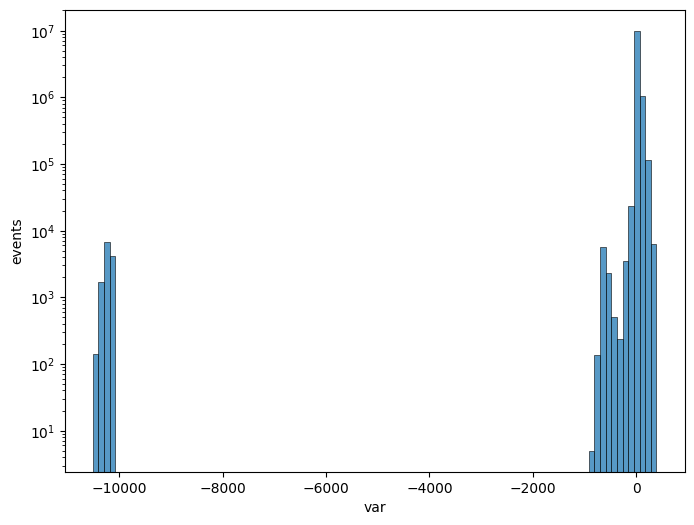

In [9]:
plt.figure(figsize=(8,6))
sn.histplot(time_residual.cpu(), bins = 100)
plt.xlabel('var')
plt.ylabel('events')
plt.yscale('log')

# 3 - Extract Valid Data

## 3.1 - Extract  valid PMT id

In [11]:
## Numpy proofs to validate pytorch tools

valid_pmt_id = np.array(np.where(pmt_type == 1)[0])   # PMT valid ID match with index of where pmt_type=1

valid_id_info_ev_i = np.array(np.where(np.in1d(hit_pmtid, valid_pmt_id))[0])
valid_id_info_ev_i

array([        0,         1,         2, ..., 131016005, 131016006,
       131016007], dtype=int64)

# 4 - Optimizar uso de Memoria

- Intentemos hacer un loop sobre subconjuntos de valid_id_info_ev e ir guardando esta información en arrays fuera del Loop;
- Librar memoria de variables cada que se reinicie el Loop entre los subconjuntos de valid_id_info_ev_i

## 4.1 - Extraer Datos Validos

In [15]:
#params to adjust the cuts--------------------------------------------
#Split Data
split = 5
#time cut
inf_cut = -5
up_cut = 7

#radia cut
radi_cut_method = True   #If true, apply radial cuts given by rad_cut_val to data
rad_cut_val = 5500
#--------------------------------------------------------------------------


# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(valid_id_info_ev_i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut depends on the simulation)
multi_time_residual_cut = []
multi_cos_angle_cut = []
#Variables necesarias para nueva normalización
multi_position_cut = []
multi_momentum_cut = []

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    #multi_time_residual = np.array([])
    multi_time_residual = []
    #multi_pmt_id_hit = np.array([])
    multi_pmt_id_hit = []
    multi_position = []
    multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        #multi_time_residual = np.append(multi_time_residual, time_residual[valid_i])
        #multi_pmt_id_hit = np.append(multi_pmt_id_hit, hit_pmtid[valid_i])
        multi_time_residual.append(time_residual[valid_i])
        multi_pmt_id_hit.append(hit_pmtid[valid_i])
        multi_position.append(position[valid_i])
        multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(mc_momentum[valid_i])
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut, split nº: ', n_loop)
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])

        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)

        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        
        scalar_product = np.dot(multi_xyz_hit[k], multi_mc_momentum[k])
        norm_1 = np.linalg.norm(multi_mc_momentum[k])
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        multi_time_residual_cut.append(multi_time_residual[i])
        multi_cos_angle_cut.append(multi_cos_angle[i])
        multi_momentum_cut.append(multi_mc_momentum[i])
        multi_position_cut.append(multi_position[i])

    #freed memory
    multi_cos_angle = None

slipt nº: 0
In radi_cut, split nº:  0
computing cos(alpha)
doing time residual cuts
slipt nº: 1
In radi_cut, split nº:  1
computing cos(alpha)
doing time residual cuts
slipt nº: 2
In radi_cut, split nº:  2
computing cos(alpha)
doing time residual cuts
slipt nº: 3
In radi_cut, split nº:  3
computing cos(alpha)
doing time residual cuts
slipt nº: 4
In radi_cut, split nº:  4
computing cos(alpha)
doing time residual cuts


Text(0.5, 1.0, 'Simulated 5 MeV e$^-$ - R < 5500(mm)')

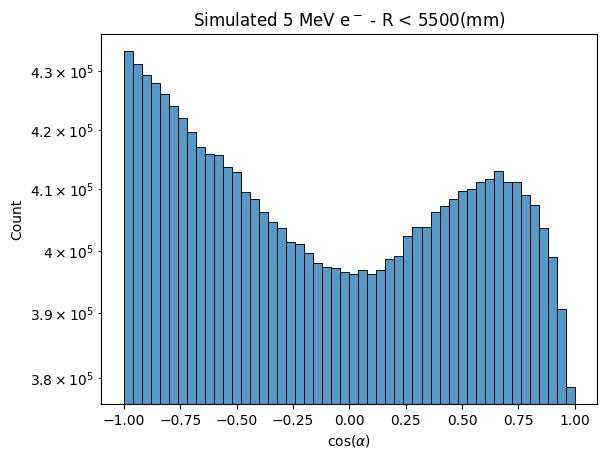

In [20]:
sn.histplot(multi_cos_angle_cut, bins = 50)
plt.xlabel(r'cos($\alpha$)')
plt.yscale('log')
plt.title(r'Simulated 5 MeV e$^-$ - R < ' + str(rad_cut_val) + '(mm)')

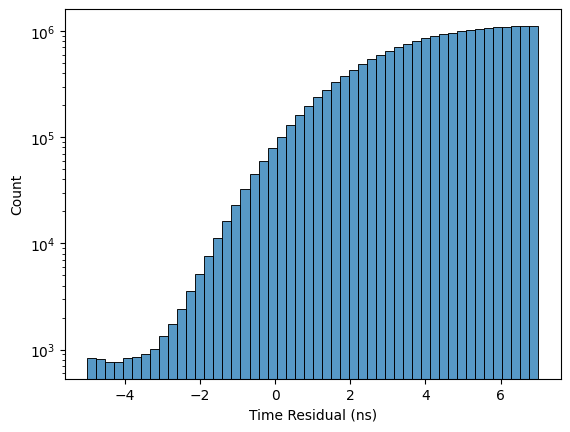

In [17]:
sn.histplot(multi_time_residual_cut, bins = 50)
plt.xlabel(r'Time Residual (ns)')
plt.yscale('log')

# 5 - Plots

## 5.1 - Time residual vs. $cos(α)$

In [12]:
%matplotlib
# 2d Histogram
bins = 40

if radi_cut_method == True:
    title = 'cos(α) vs. Time Residual Multiple evID - 10MeV - random (dir, vtx) \n volume cut using recons. position'

else:
    title = 'cos(α) vs. time residual - Multiple evID - 10MeV - random (dir,vtx)'

plt.figure(figsize=(10,8))
sn.set_style(rc = {'axes.facecolor': 'black'})
sn.histplot(x = multi_cos_angle_cut, y = multi_time_residual_cut, bins = [bins, bins], stat='count', cbar = 'True', cmap = cm.nipy_spectral)
plt.ylabel('time residual')
plt.xlabel('cos(α)')
plt.title(title, fontsize= 10)

#equal acis ration
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.show()
#plt.savefig('figs/Low Stat/cos(α) vs. Time Residual Multiple evID - 10MeV - random (dir, vtx) - volume cut using recons. position.png', format = 'png')

Using matplotlib backend: TkAgg


## 5.2 - Normalization

In [52]:
#Transforma Data into an Image Matrix

H, xedges, yedges = np.histogram2d(x = multi_cos_angle_cut, y = multi_time_residual_cut, bins = [bins, bins])

#Now recover the data axis representation of time residual vs cos(alpha)
left = np.min(multi_time_residual_cut)
right = np.max(multi_time_residual_cut)
bottom = np.min(multi_cos_angle_cut)
top = np.max(multi_cos_angle_cut)

#Titles
title = 'cos(α) - Multiple evID - 10MeV - random (dir, vtx) \n volume cut using recons. position '
ylabel = 'cos(α)'
xlabel = 'time residual'

plt.figure(figsize=(10,8))
plt.imshow(H, extent = [left, right, top, bottom], aspect="auto" ) #---> Here is our image as a Matrix Pixel
plt.title(title, fontsize= 10)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
#plt.savefig('figs/Low Stat/' + title +'(imshow).png', format = 'png')

#### 4.1.2.1 - Normalization by Nhits

In [53]:
# sum of hits in each bin = sum over each column element of the matrix.
sum_hit = np.sum(H,axis=0)  

H_normalized1 = H / sum_hit

N1title = 'Normalization by NHits - Multiple evID - 10MeV - random (dir, vtx) \n volume cut using recons. position'

plt.figure(figsize=(10,8))
plt.imshow(H_normalized1, extent = [left, right, top, bottom], aspect="auto" )
plt.title(N1title)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.colorbar()
#plt.savefig('figs/Low Stat/Normalization by NHits - Multiple evID - 10MeV - random (dir, vtx)-volume cut using recons. position.png', format = 'png')